In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py

# import cortex
import numpy as np

# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.spatial.distance import cdist

from util import plot, subject
from util.path import Path
from util.atlas import Atlas  # , get_brainmask
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
modelname = "model-gpt2-2b_layer-24"
# modelname = "model-opt-7b_layer-23"

features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding/trialmot6"
# encmodel = "encoding_trialmot6"
cache = encmodel.split("/")[-1]

modelname, encmodel, cache

('model-gpt2-2b_layer-24', 'encoding/trialmot6', 'trialmot6')

In [4]:
cachedir = f"cache/figure-mbc-lags/{modelname}/{cache}"
!mkdir -p $cachedir

In [5]:
catlas = Atlas.load("custom_glasser_group")
len(catlas)

20

In [6]:
lags = np.arange(-10, 11)
lags * 1.5

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [16]:
# subA prod+comp pred -> subB prod+comp actual
# by first shifting the signal, then taking out production time points, then correlating

sub_mbc_scores = []
# mbc_scores = defaultdict(list)

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA preds
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        # prod_predA = f["cv_preds"][:, -2]
        # comp_predA = f["cv_preds"][:, -1]
        # prodmaskA = f["cv_prodmask"][...]
        predA = f["cv_preds"][:, -2:].sum(1)

    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        Y_predsB = f["cv_preds"][...]
        nuis_predsB = Y_predsB[:, :-2].sum(1)
    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    resB = dataB.reshape(5, 240, -1) - nuis_predsB

    predA = catlas.vox_to_parc(predA)
    resB = catlas.vox_to_parc(resB)

    # per run
    n_folds = 5
    sub_scores = np.zeros((n_folds, len(lags), len(catlas), len(catlas)), dtype=np.float32)
    for k in range(n_folds):
        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = predA[k, :lag]
                trialB = resB[k, -lag:]
            elif lag > 0:
                trialA = predA[k, lag:]
                trialB = resB[k, :-lag]
            else:
                trialA = predA[k]
                trialB = resB[k]

            sub_scores[k, i] = cdist(trialA.T, trialB.T, metric='correlation')

    sub_mbc_scores.append(sub_scores)

    # break

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

100%|██████████| 58/58 [13:07<00:00, 13.58s/it]


(58, 5, 3, 20, 20)

In [32]:
# save
with h5py.File(f"{cachedir}/mbc-prodcomp_pred-actual.hdf5", "w") as f:
    f.create_dataset(name="sub_mbc_prod", data=sub_mbc_prod)

In [13]:
# subA prod pred -> subB comp actual
# by first shifting the signal, then taking out production time points, then correlating

sub_mbc_scores = []
# mbc_scores = defaultdict(list)

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA preds
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        predA = f["cv_preds"][:, -2]
        # comp_predA = f["cv_preds"][:, -1]
        prodmaskA = f["cv_prodmask"][...]
        # predA = f["cv_preds"][:, -2:].sum(1)

    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        Y_predsB = f["cv_preds"][...]
        nuis_predsB = Y_predsB[:, :-2].sum(1)
    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    resB = dataB.reshape(5, 240, -1) - nuis_predsB

    predA = catlas.vox_to_parc(predA)
    resB = catlas.vox_to_parc(resB)

    # per run
    n_folds = 5
    sub_scores = np.zeros((n_folds, len(lags), len(catlas), len(catlas)), dtype=np.float32)
    for k in range(n_folds):
        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = predA[k, :lag]
                trialB = resB[k, -lag:]
                trialM = prodmaskA[k][:lag]
            elif lag > 0:
                trialA = predA[k, lag:]
                trialB = resB[k, :-lag]
                trialM = prodmaskA[k][lag:]
            else:
                trialA = predA[k]
                trialB = resB[k]
                trialM = prodmaskA[k]

            sub_scores[k, i] = cdist(trialA[trialM].T, trialB[trialM].T, metric='correlation')

    sub_mbc_scores.append(sub_scores)

    # break

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

100%|██████████| 58/58 [08:35<00:00,  8.88s/it]


(58, 5, 21, 20, 20)

In [14]:
# save
with h5py.File(f"{cachedir}/mbc-prod_pred-actual.hdf5", "w") as f:
    f.create_dataset(name="sub_mbc_prod", data=sub_mbc_prod)

In [9]:
with h5py.File(f"{cachedir}/mbc-prod_pred-actual.hdf5", "r") as f:
    sub_mbc_prod = f["sub_mbc_prod"][...]

In [10]:
avg_mbc = (1 - sub_mbc_prod).mean((0,1))
avg_mbc.shape

(21, 20, 20)

In [11]:
catlas.labels[:10]

['LH_LangS',
 'LH_MOT',
 'LH_AUD',
 'LH_LangT',
 'LH_LangPT',
 'LH_LangM',
 'LH_LangF',
 'LH_INS',
 'LH_Misc',
 'LH_DMN']

In [32]:
hemi = 'RH'
seed = 'LangT'
nets = ['AUD', 'LangT', 'LangPT', 'LangF', 'DMN']

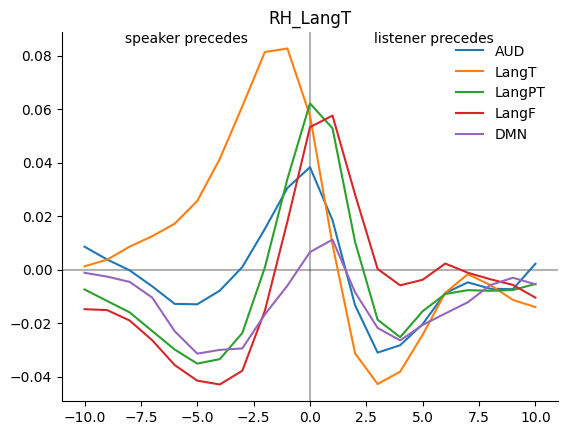

In [36]:
fig, ax = plt.subplots()

ax.axvline(0, c="k", alpha=0.3)
ax.axhline(0, c="k", alpha=0.3)

seedROI = f'{hemi}_{seed}'
seedId = catlas.labels.index(seedROI)

for net in nets:
    targetROI = f'{hemi}_{net}'
    targetid = catlas.labels.index(targetROI)
    values = avg_mbc[:, seedId, targetid]
    ax.plot(lags, values, label=net)

ax.text(0.25, 1, "speaker precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center",)
ax.text(0.75, 1, "listener precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title(seedROI)
ax.legend(frameon=False)

fig.show()

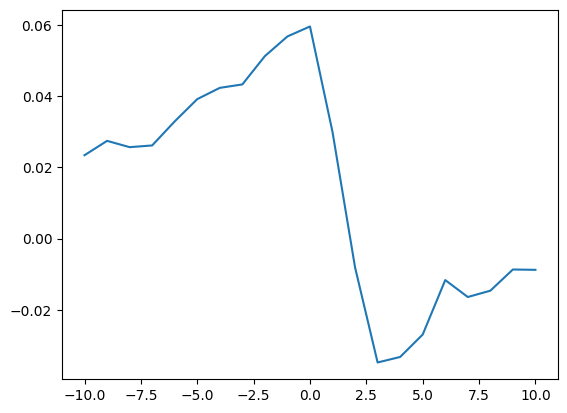

In [18]:
plt.plot(lags, avg_mbc[:, 11, 13])